In [1]:
# Import Libraries

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Download daily data for Ethereum from Yahoo Finance
eth_data = yf.download('ETH-USD', start='2020-06-21', end='2025-06-21')

# Reset index and ensure date is datetime
eth_data.reset_index(inplace=True)
eth_data['Date'] = pd.to_datetime(eth_data['Date'])
eth_data.set_index('Date', inplace=True)

# Keep only relevant columns
eth_data = eth_data[['Open', 'High', 'Low', 'Close', 'Volume']]
eth_data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
eth_data.head()

,Close,High,Low,Open,Volume
Date,,,,,
2020-06-21,229.216141,232.358948,228.492996,228.989822,5600408178
2020-06-22,229.003372,243.776016,228.934738,242.533188,9079586552
2020-06-23,242.537018,244.864410,239.759735,244.142151,6624530348
2020-06-24,244.185928,248.508026,232.807739,235.772461,8815030025
2020-06-25,235.702850,236.053406,230.296600,232.944489,7010426122


In [4]:
eth_data.index = pd.to_datetime(eth_data.index)

eth_data['Close_30D'] = eth_data['Close'].rolling(window=30).mean()
eth_data['Close_90D'] = eth_data['Close'].rolling(window=90).mean()

In [5]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=eth_data.index, y=eth_data['Close'], mode='lines', name='Daily Close Price'))

fig.update_layout(
    title='Ethereum Daily Close Price Over Time',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    template='plotly_white'
)
fig.show()


In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=eth_data.index, y=eth_data['Close'], mode='lines', name='Daily Close Price', line=dict(color='lightgray')))
fig.add_trace(go.Scatter(x=eth_data.index, y=eth_data['Close_30D'], mode='lines', name='30-Day Rolling Mean', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=eth_data.index, y=eth_data['Close_90D'], mode='lines', name='90-Day Rolling Mean', line=dict(color='green')))

fig.update_layout(
    title='Ethereum Price with Rolling Averages',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    template='plotly_white'
)
fig.show()

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=eth_data.index, y=eth_data['Volume'], mode='lines', name='Volume', line=dict(color='purple')))

fig.update_layout(
    title='Ethereum Trading Volume Over Time',
    xaxis_title='Date',
    yaxis_title='Volume',
    template='plotly_white'
)
fig.show()


In [8]:
import plotly.graph_objs as go

# Plot Daily Returns

# Calculate Daily Return (percentage change)
eth_data['Daily_Return'] = eth_data['Close'].pct_change()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=eth_data.index,
    y=eth_data['Daily_Return'],
    mode='lines',
    name='Daily Return',
    line=dict(color='red', width=1)
))

# Layout
fig.update_layout(
    title='Daily Return (Volatility) of Ethereum',
    xaxis_title='Date',
    yaxis_title='Daily % Change',
    template='plotly_white'
)

fig.show()


In [9]:
fig = go.Figure()
fig.add_trace(go.Box(x=eth_data['Close'], name='Close Price', boxpoints='outliers', marker_color='lightblue'))

fig.update_layout(
    title='Ethereum Close Price Distribution (Boxplot)',
    xaxis_title='Close Price (USD)',
    template='plotly_white'
)
fig.show()

In [10]:
import plotly.graph_objs as go

# Resample to monthly average
monthly_avg = eth_data['Close'].resample('M').mean()

# Create Plotly line chart
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=monthly_avg.index,
    y=monthly_avg,
    mode='lines+markers',
    name='Monthly Avg Close',
    line=dict(color='darkgreen')
))

# Update layout
fig.update_layout(
    title="Monthly Average Ethereum Price (Seasonality Check)",
    xaxis_title="Month",
    yaxis_title="Average Close Price (USD)",
    template="plotly_white",
    hovermode="x unified"
)

fig.show()


In [11]:
eth_data.describe()

,Close,High,Low,Open,Volume,Close_30D,Close_90D,Daily_Return
count,1826.000000,1826.000000,1826.000000,1826.000000,1.826000e+03,1797.000000,1737.000000,1825.000000
mean,2192.168298,2251.116586,2127.489378,2193.160352,1.733159e+10,2204.871812,2237.119725,0.002188
std,1011.302093,1038.598745,979.363369,1009.902411,1.106320e+10,980.093447,912.599547,0.041824
min,222.914490,228.598282,219.472672,222.959793,2.081626e+09,234.653212,327.442292,-0.278780
25%,1584.506409,1632.691559,1551.772095,1586.266418,9.702066e+09,1616.515458,1570.690845,-0.017578
50%,2052.607666,2102.600220,1985.065063,2053.989624,1.500356e+10,2096.699475,2192.947660,0.001308
75%,2972.976746,3043.667297,2889.290222,2972.115662,2.183747e+10,3013.530184,2944.927477,0.021510
max,4810.071289,4891.704590,4718.039062,4812.087402,9.245355e+10,4452.379142,4130.525640,0.261516


In [12]:
# ADF test on raw Close prices
adf_result_raw = adfuller(eth_data['Close'].dropna())

print("ADF Test on Raw Closing Prices")
print(f"ADF Statistic     : {adf_result_raw[0]}")
print(f"p-value           : {adf_result_raw[1]}")
print("Critical Values   :")
for key, value in adf_result_raw[4].items():
    print(f"   {key} : {value}")

if adf_result_raw[1] > 0.05:
    print("Conclusion: Series is NON-STATIONARY (p > 0.05), differencing is required.")
else:
    print("Conclusion: Series is STATIONARY (p <= 0.05), differencing is NOT required.")


ADF Test on Raw Closing Prices
ADF Statistic     : -2.5599157550777534
p-value           : 0.10156804979626749
Critical Values   :
   1% : -3.4339500836471712
   5% : -2.8631302362582534
   10% : -2.567616588375528
Conclusion: Series is NON-STATIONARY (p > 0.05), differencing is required.


In [13]:
import plotly.graph_objs as go

# Ensure differenced column exists
eth_data['Close_diff'] = eth_data['Close'].diff()

# Create Plotly figure
fig = go.Figure()

# Non-stationary (raw) series
fig.add_trace(go.Scatter(
    x=eth_data.index,
    y=eth_data['Close'],
    mode='lines',
    name='Raw Close Price (Non-Stationary)',
    line=dict(color='blue')
))

# Stationary (differenced) series
fig.add_trace(go.Scatter(
    x=eth_data.index,
    y=eth_data['Close_diff'],
    mode='lines',
    name='Differenced Close Price (Stationary)',
    line=dict(color='red')
))

# Layout settings
fig.update_layout(
    title="Ethereum Price: Non-Stationary vs Stationary Series",
    xaxis_title="Date",
    yaxis_title="Price / Differenced Price",
    template="plotly_white",
    legend=dict(x=0.01, y=0.99)
)

fig.show()


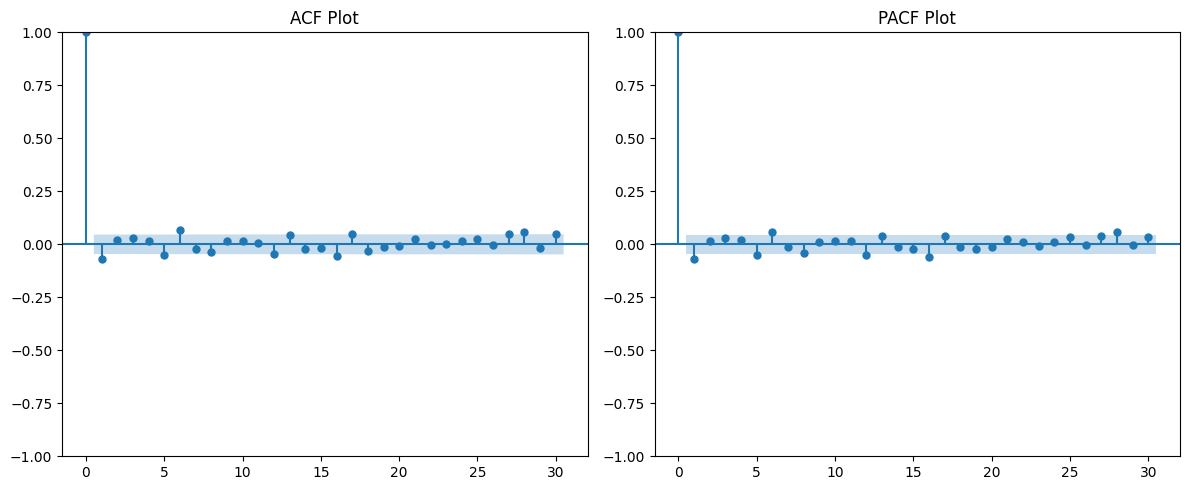

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

eth_diff = eth_data['Close_diff'].dropna()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(eth_diff, lags=30, ax=plt.gca(), title="ACF Plot")

plt.subplot(1, 2, 2)
plot_pacf(eth_diff, lags=30, ax=plt.gca(), method="ywm", title="PACF Plot")

plt.tight_layout()
plt.show()


In [15]:
from statsmodels.tsa.arima.model import ARIMA

# Define (p,d,q) based on ACF/PACF
model = ARIMA(eth_data['Close'], order=(1,1,1))  # try (1,1,1) or test multiple

# Fit the model
model_fit = model.fit()

eth_data['Fitted_ARIMA'] = model_fit.fittedvalues


# Print summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1826
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10963.174
Date:                Thu, 26 Jun 2025   AIC                          21932.349
Time:                        16:45:09   BIC                          21948.877
Sample:                    06-21-2020   HQIC                         21938.446
                         - 06-20-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1977      0.211     -0.938      0.348      -0.611       0.215
ma.L1          0.1300      0.214      0.607      0.544      -0.290       0.550
sigma2      9689.7303    148.701     65.163      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [16]:
# Get in-sample predictions

# Plot actual vs fitted
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=eth_data.index, y=eth_data['Close'], name='Actual Close Price'))
fig.add_trace(go.Scatter(x=eth_data.index, y=eth_data['Fitted_ARIMA'], name='ARIMA Fitted Values', line=dict(color='orange')))

fig.update_layout(
    title="ARIMA Model Fitted vs Actual Close Price",
    xaxis_title="Date",
    yaxis_title="Price (USD)",
    template="plotly_white"
)
fig.show()


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Remove NaNs due to differencing at the start
actual = eth_data['Close'].iloc[1:]  # true values
predicted = eth_data['Fitted_ARIMA'].iloc[1:]  # predicted by ARIMA

# RMSE
rmse = np.sqrt(mean_squared_error(actual, predicted))
# MAPE
mape = mean_absolute_percentage_error(actual, predicted) * 100

print(f" Model Evaluation Metrics")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


 Model Evaluation Metrics
Root Mean Square Error (RMSE): 98.32
Mean Absolute Percentage Error (MAPE): 2.89%


In [18]:
import plotly.graph_objs as go

# Calculate residuals
eth_data['Residuals'] = actual - predicted

# Plot residuals
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=eth_data.index[1:],  # exclude first NaN row
    y=eth_data['Residuals'].iloc[1:],
    mode='lines',
    name='Residuals',
    line=dict(color='crimson')
))

fig.update_layout(
    title="Residuals of ARIMA Model Predictions",
    xaxis_title="Date",
    yaxis_title="Prediction Error",
    template="plotly_white"
)

fig.show()


In [19]:
# Forecast next 30 days
forecast = model_fit.get_forecast(steps=30)

# Extract forecasted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()


In [20]:
# Last date in dataset
last_date = eth_data.index[-1]

# Create future date range for 30 days
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Convert forecasted values into a DataFrame
forecast_df = pd.DataFrame({
    'Forecast': forecast_mean.values,
    'Lower_CI': forecast_ci.iloc[:, 0].values,
    'Upper_CI': forecast_ci.iloc[:, 1].values
}, index=future_dates)


In [21]:
import plotly.graph_objs as go

fig = go.Figure()

# Historical prices
fig.add_trace(go.Scatter(
    x=eth_data.index,
    y=eth_data['Close'],
    mode='lines',
    name='Historical Price',
    line=dict(color='blue')
))

# Forecasted mean
fig.add_trace(go.Scatter(
    x=forecast_df.index,
    y=forecast_df['Forecast'],
    mode='lines',
    name='Forecasted Price',
    line=dict(color='orange', dash='dash')
))

# Confidence interval - shaded area
fig.add_trace(go.Scatter(
    x=forecast_df.index.tolist() + forecast_df.index[::-1].tolist(),
    y=forecast_df['Upper_CI'].tolist() + forecast_df['Lower_CI'][::-1].tolist(),
    fill='toself',
    fillcolor='rgba(255,165,0,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    name='95% Confidence Interval'
))

# Layout
fig.update_layout(
    title="Ethereum 30-Day Price Forecast using ARIMA",
    xaxis_title="Date",
    yaxis_title="Price (USD)",
    template='plotly_white',
    legend=dict(x=0.01, y=0.99)
)

fig.show()
